In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
import seaborn as sns
import keras_tuner
import scipy
# from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch, Tuner

In [2]:
RANDOM_STATE = 42
ROWS = 48
COLUMNS = 48
BATCH_SIZE = 64
EPOCHS = 30
CLASSES = 7

### Load Data

In [3]:
files_path = "./FinalProjData"

emotions2int = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
int2emotions = {v:k for k,v in emotions2int.items()}

dic = {'images':[], 'labels':[], 'purpose':[], 'image_path':[]}

for d in os.listdir(f'{files_path}/fer2013/'):
    print(d)
    for emotion in os.listdir(f'{files_path}/fer2013/{d}'):
        print(emotion)
        for i in os.listdir(f'{files_path}/fer2013/{d}/{emotion}'):
            img = cv2.imread(f'{files_path}/fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)

            dic['images'].append(img)
            dic['labels'].append(emotion)
            dic['image_path'].append(f'{files_path}/fer2013/{d}/{emotion}/{i}')

            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('S')

df = pd.DataFrame(dic)
df.head()

test
angry
disgust
fear
happy
neutral
sad
surprise
train
angry
disgust
fear
happy
neutral
sad
surprise


,images,labels,purpose,image_path
0,"[[[46], [34], [26], [23], [12], [32], [35], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
1,"[[[55], [33], [54], [32], [26], [21], [50], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
2,"[[[123], [123], [126], [131], [124], [69], [10...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
3,"[[[255], [255], [255], [255], [255], [255], [2...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...
4,"[[[127], [121], [124], [137], [123], [118], [1...",angry,S,./FinalProjData/fer2013/test/angry/PrivateTest...


In [4]:
train_data = df[df['purpose']=='T'].sample(frac=0.8, random_state=RANDOM_STATE)
val_data = df[df['purpose']=='T'].drop(train_data.index, axis=0)
test_data = df[df['purpose']=='S']

In [5]:
len(train_data)

22967

In [6]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

In [7]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [8]:
test_data['labels'].value_counts()

labels
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64

In [9]:
happy_df = train_data[train_data['labels']=='happy']
neutral_df = train_data[train_data['labels']=='neutral']
sad_df = train_data[train_data['labels']=='sad']
fear_df = train_data[train_data['labels']=='fear']
angry_df = train_data[train_data['labels']=='angry']
surprise_df = train_data[train_data['labels']=='surprise']
disgust_df = train_data[train_data['labels']=='disgust']

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df, disgust_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose,image_path
0,"[[[64], [55], [60], [55], [48], [51], [49], [4...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
1,"[[[212], [56], [4], [4], [39], [71], [75], [73...",sad,T,./FinalProjData/fer2013/train/sad/Training_641...
2,"[[[228], [231], [232], [231], [228], [227], [2...",neutral,T,./FinalProjData/fer2013/train/neutral/Training...
3,"[[[103], [147], [157], [126], [120], [135], [1...",angry,T,./FinalProjData/fer2013/train/angry/Training_1...
4,"[[[0], [2], [0], [0], [8], [12], [0], [1], [2]...",fear,T,./FinalProjData/fer2013/train/fear/Training_76...


In [10]:
train_data['labels'].value_counts()

labels
happy       5813
neutral     3965
sad         3834
fear        3284
angry       3218
surprise    2490
disgust      363
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

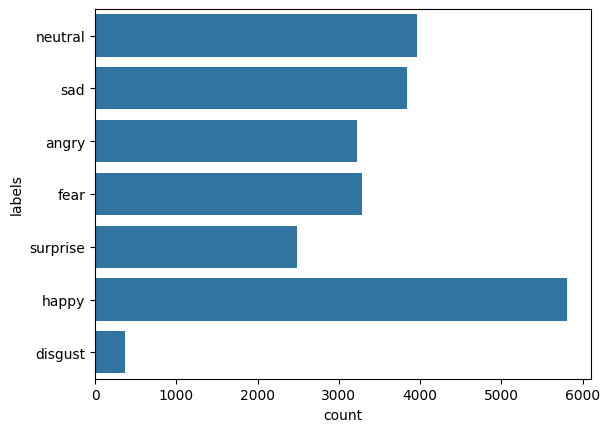

In [11]:
sns.countplot(train_data['labels'])

In [12]:
val_data['labels'].value_counts()

labels
happy       1402
neutral     1000
sad          996
fear         813
angry        777
surprise     681
disgust       73
Name: count, dtype: int64

In [13]:
# Convert dataframe to numpy array
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

test_labels = list(test_data['labels'].replace(emotions2int))
test_labels = to_categorical(test_labels)

# train_data = train_data['images']
# val_data = val_data['images']

In [14]:
train_data.shape

(22967, 4)

In [15]:
val_data.shape

(5742, 4)

In [16]:
from keras.regularizers import L1L2
from keras.metrics import AUC, Accuracy, MeanSquaredError

def create_model_name(dropout: bool, activation: str, optimizer, regularizer, loss):
    if regularizer and isinstance(regularizer, L1L2):
        regularizer='l1l2'

    optimizer = optimizer._name

    loss = loss.name

    model_name = f"dropout_{dropout}_activation_{activation}_optimizer_{optimizer}_regularizer_{regularizer}_loss_{loss}"
    return model_name


def parameterized_build_model(dropout: bool, activation: str, optimizer, regularizer, loss, input_shape: tuple,
                              classes: int):
    model = Sequential()

    # First Block
    model.add(Conv2D(64,(3,3),activation=activation,input_shape=input_shape,kernel_initializer='he_normal',
                     padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation=activation,input_shape=input_shape,kernel_initializer='he_normal',
                     padding='same', kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Second Block
    model.add(Conv2D(128,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Third Block
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
                     kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Fourth Block
    model.add(Conv2D(512,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
        kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(512,(3,3),activation=activation,kernel_initializer='he_normal',padding='same',
        kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    if dropout:
        model.add(Dropout(0.2))

    # Fifth Block
    model.add(Flatten())
    model.add(Dense(256,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Sixth Block
    model.add(Dense(128,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Seventh Block
    model.add(Dense(64,activation=activation,kernel_initializer='he_normal', kernel_regularizer=regularizer,
                     bias_regularizer=regularizer))
    model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))

    # Eighth Block
    model.add(Dense(classes, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=regularizer,
                    bias_regularizer=regularizer))

    model.compile(metrics=['accuracy', AUC(), 'mse'],
                optimizer=optimizer,
                loss=loss)

    return model


#print(model.summary())

Method for selecting the best parameters

In [24]:
from keras.optimizers import Adam, SGD
from keras.regularizers import l1_l2, l1, l2
from keras.losses import CategoricalCrossentropy
import tensorflow_addons as tfa

opt_map = {
    'adam': Adam(learning_rate=0.01),
    'rmsprop': RMSprop(learning_rate=0.01),
    'sgd': SGD(learning_rate=0.01)
}

loss_map = {
    'cc': CategoricalCrossentropy(),
    'kl': 'kullback_leibler_divergence'
}

activation_map = {
    "elu": "elu",
    "relu": "relu",
    "tanh": "tanh",
    "mish": tfa.activations.mish
}

regularizers = {
    'l1': l1(1e-5),
    'l2': l2(1e-5),
    'l1l2': l1_l2(1e-5, 1e-5),
    'None': None
}

def build_model(hp: keras_tuner.HyperParameters):
    dropout = hp.Boolean('dropout')
    activation = hp.Choice(name='activation',values=["elu", "relu", "tanh", "mish"])
    regularizer = hp.Choice(name='regularizer',values=['None', 'l1', 'l2', 'l1l2'])
    optimizer = hp.Choice(name='optimizer', values=['adam', 'rmsprop', 'sgd'])
    loss = hp.Choice(name='loss',values=['cc'])

    model = parameterized_build_model(activation=activation_map[activation],
                                      dropout=dropout,
                                      optimizer=opt_map[optimizer],
                                      regularizer=regularizers[regularizer],
                                      loss=loss_map[loss],
                                      input_shape=(ROWS, COLUMNS, 1),
                                      classes=CLASSES)
    return model

In [25]:
# ModelCheckpoint(f'{files_path}/model/7_class_emotion_detector_{model_name}.h5',
#                      save_best_only=True,
#                      mode='min',
#                      monitor='val_loss',
#                      verbose=1)
from typing import Union
from keras import Model

def run_model(model: Union[Tuner, Model], train_data: pd.DataFrame, val_data: pd.DataFrame, epochs: int,
              batch_size: int):
    callbacks = [
        EarlyStopping(patience=10, verbose=1, min_delta=0, monitor='val_loss', restore_best_weights=False),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001),
        TensorBoard(log_dir="logs/tb_logs")
    ]
    # Data Augmentation setup for training data
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # Data generator for validation data (No augmentation)
    val_datagen = ImageDataGenerator()

    # Create generators to read images from dataframe
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=None,  # Directory is None since paths are absolute
        x_col='image_path',
        y_col='labels',
        target_size=(48, 48),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=None,
        x_col='image_path',
        y_col='labels',
        target_size=(48, 48),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False)

    train_samples = len(train_data)
    validation_samples = len(val_data)

    # Training the model using generators
    if isinstance(model, Model):
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=train_samples//batch_size,
            validation_data=validation_generator,
            validation_steps=validation_samples//batch_size,
            callbacks=callbacks
        )
        return history
    else:
        model.search(
            train_generator,
            steps_per_epoch=train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_samples // batch_size,
            callbacks=callbacks)
        return model

### Ground Truth Model

In [48]:
model = parameterized_build_model(activation="elu",
                                    dropout=True,
                                    optimizer="rmsprop",
                                    regularizer=None,
                                    loss=loss_map['cc'],
                                    input_shape=(ROWS, COLUMNS, 1),
                                    classes=CLASSES)


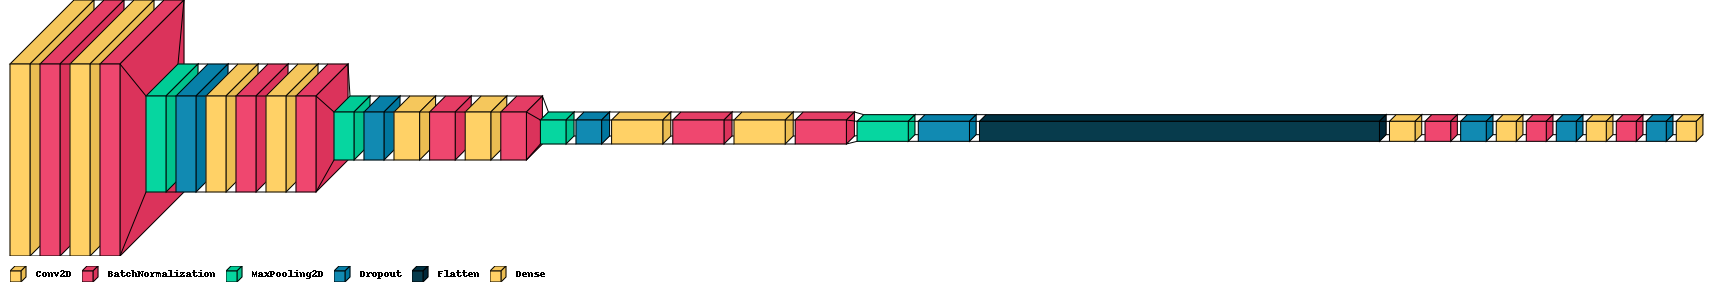

In [49]:
import visualkeras
visualkeras.layered_view(model, legend=True, to_file='base_model.png')

In [50]:
history = run_model(model, train_data, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Epoch 1/30
358/358 [==============================] - 37s 95ms/step - loss: 2.3494 - accuracy: 0.1815 - auc_4: 0.5557 - mse: 0.1379 - val_loss: 1.8797 - val_accuracy: 0.2105 - val_auc_4: 0.6180 - val_mse: 0.1212 - lr: 0.0010
Epoch 2/30
358/358 [==============================] - 27s 75ms/step - loss: 1.8834 - accuracy: 0.2228 - auc_4: 0.6315 - mse: 0.1213 - val_loss: 1.7681 - val_accuracy: 0.2554 - val_auc_4: 0.6805 - val_mse: 0.1165 - lr: 0.0010
Epoch 3/30
 20/358 [>.............................] - ETA: 21s - loss: 1.8203 - accuracy: 0.2398 - auc_4: 0.6606 - mse: 0.1182

KeyboardInterrupt: 

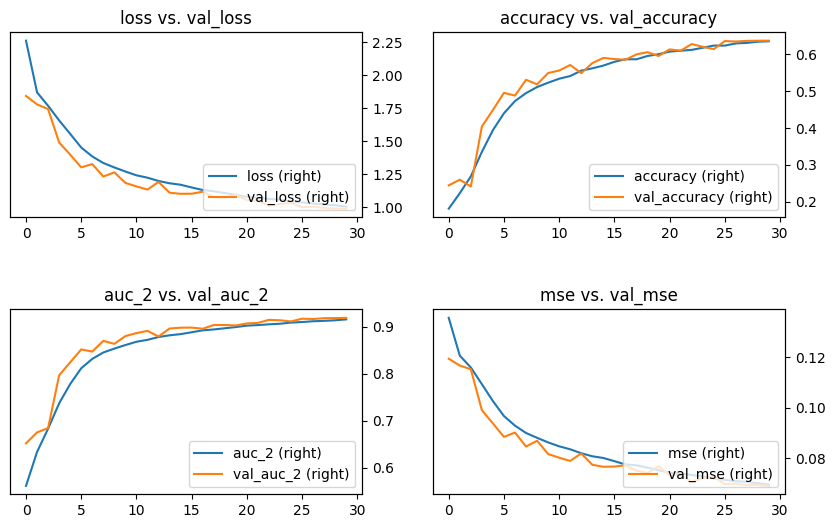

In [ ]:
import matplotlib.pyplot as plt
from math import ceil
# Grid of all metrics and their validations

metrics = history.model.metrics_names

fig, axs = plt.subplots(ceil(len(metrics) / 2), 2, figsize=(16, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

# Confusion matrix for each classifier
for i, metric in enumerate(metrics):
    # plot confusion matrix
    df = pd.DataFrame({k:v for k,v in history.history.items() if k in [metric, f'val_{metric}']})
    df[metric].plot(secondary_y=True, figsize=(10,6), ax=axs[i // 2, i % 2]);
    disp = df[f'val_{metric}'].plot(secondary_y=True, ax=axs[i // 2, i % 2]);
    disp.legend(loc='lower right')

    # add the model name as a title
    axs[i // 2, i % 2].set_title(f"{metric} vs. val_{metric}")

    # Increase the vertical margins
    axs[i // 2, i % 2].set_ymargin(200)

In [ ]:
model.save('FinalProjData/model/7_class_emotion_detector_with_transformations.h5')

In [ ]:
test_datagen = ImageDataGenerator()
test_datagen = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False)

model.evaluate(test_datagen)

Found 7178 validated image filenames belonging to 7 classes.
113/113 [==============================] - 4s 33ms/step - loss: 0.9810 - accuracy: 0.6393 - auc_2: 0.9198 - mse: 0.0687


[0.9810366630554199,
 0.639314591884613,
 0.9197520017623901,
 0.06872627139091492]

### Ground truth with oversampling

In [94]:
train_data[~(train_data['labels'] == 'disgust')].groupby('labels').count()

,images,purpose,image_path
labels,,,
angry,3218,3218,3218
fear,3284,3284,3284
happy,5813,5813,5813
neutral,3965,3965,3965
sad,3834,3834,3834
surprise,2490,2490,2490


<Axes: xlabel='count', ylabel='labels'>

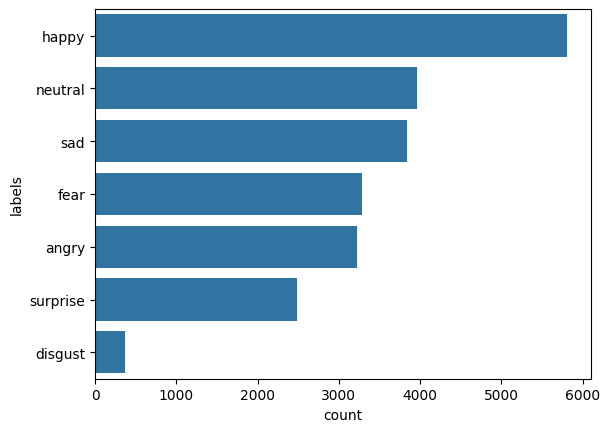

In [106]:
# duplicate the disgust records eight times and add the other labels
with_oversamping = train_data[train_data['labels'] == 'disgust']
with_oversamping = pd.concat([with_oversamping]*6, ignore_index=True)
with_oversamping = pd.concat([with_oversamping, train_data[~(train_data['labels'] == 'disgust')]], ignore_index=True)

sns.countplot(train_data['labels'], order=with_oversamping['labels'].value_counts().index)

In [97]:
model_with_oversamping = parameterized_build_model(activation="elu",
                                    dropout=True,
                                    optimizer="rmsprop",
                                    regularizer=None,
                                    loss=loss_map['cc'],
                                    input_shape=(ROWS, COLUMNS, 1),
                                    classes=CLASSES)

history = run_model(model_with_oversamping, with_oversamping, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Found 24782 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Epoch 1/30
387/387 [==============================] - 42s 100ms/step - loss: 2.3540 - accuracy: 0.1763 - auc_1: 0.5378 - mse: 0.1376 - val_loss: 2.4873 - val_accuracy: 0.1601 - val_auc_1: 0.4858 - val_mse: 0.1377 - lr: 0.0010
Epoch 2/30
387/387 [==============================] - 25s 64ms/step - loss: 1.9563 - accuracy: 0.2081 - auc_1: 0.5876 - mse: 0.1231 - val_loss: 1.8169 - val_accuracy: 0.2595 - val_auc_1: 0.6719 - val_mse: 0.1178 - lr: 0.0010
Epoch 3/30
387/387 [==============================] - 28s 71ms/step - loss: 1.8359 - accuracy: 0.2584 - auc_1: 0.6511 - mse: 0.1179 - val_loss: 1.7133 - val_accuracy: 0.3162 - val_auc_1: 0.7190 - val_mse: 0.1119 - lr: 0.0010
Epoch 4/30
387/387 [==============================] - 25s 64ms/step - loss: 1.7359 - accuracy: 0.3169 - auc_1: 0.7016 - mse: 0.1121 - val_loss: 1.5213 - val_accuracy: 0.4082 - val_auc_1: 0.7952 - val_m

In [98]:
test_datagen = ImageDataGenerator()
test_datagen = test_datagen.flow_from_dataframe(
    dataframe=with_oversamping,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False)

model_with_oversamping.evaluate(test_datagen)

Found 24782 validated image filenames belonging to 7 classes.
388/388 [==============================] - 10s 26ms/step - loss: 0.7943 - accuracy: 0.7062 - auc_1: 0.9470 - mse: 0.0570


[0.7943457365036011,
 0.7061980366706848,
 0.9469597339630127,
 0.0569753423333168]

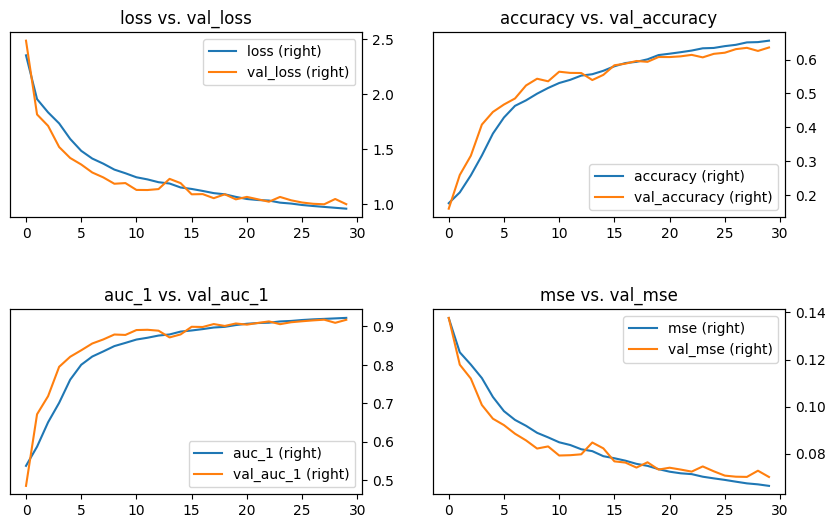

In [99]:
import matplotlib.pyplot as plt
from math import ceil
# Grid of all metrics and their validations

metrics = history.model.metrics_names

fig, axs = plt.subplots(ceil(len(metrics) / 2), 2, figsize=(16, 12), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

# Confusion matrix for each classifier
for i, metric in enumerate(metrics):
    # plot confusion matrix
    df = pd.DataFrame({k:v for k,v in history.history.items() if k in [metric, f'val_{metric}']})
    df[metric].plot(secondary_y=True, figsize=(10,6), ax=axs[i // 2, i % 2]);
    disp = df[f'val_{metric}'].plot(secondary_y=True, ax=axs[i // 2, i % 2]);
    disp.legend(loc='best')

    # add the model name as a title
    axs[i // 2, i % 2].set_title(f"{metric} vs. val_{metric}")

    # Increase the vertical margins
    axs[i // 2, i % 2].set_ymargin(200)

In [100]:
test_datagen

225/225 [==============================] - 3s 11ms/step


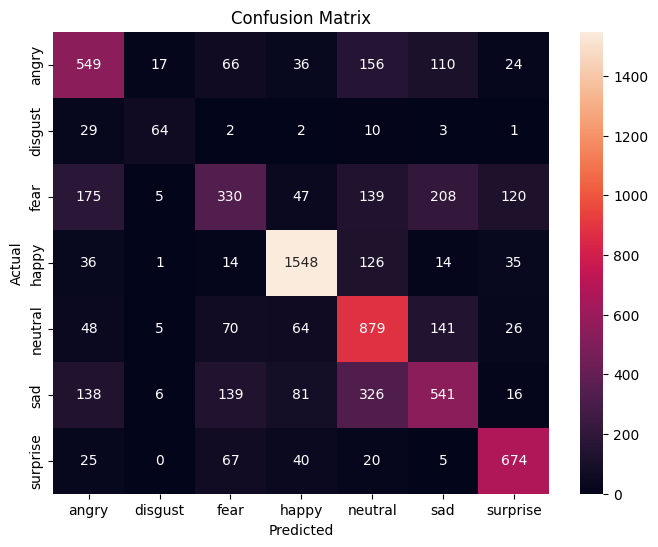

In [101]:
#cm = confusion_matrix(test_labels.argmax(axis=1), model_with_oversamping.predict(np.array(list(test_data['images']))).argmax(axis=1), labels=np.arange(CLASSES))
#sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotions2int.keys(), yticklabels=emotions2int.keys())from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_true are the true labels and y_pred are the predicted labels
unique_classes = set(range(CLASSES))  # Get unique classes

y_pred = model_with_oversamping.predict(np.array(list(test_data['images']))).argmax(axis=1)
y_true = np.array(list(test_data['labels']))

conf_matrix = confusion_matrix(y_true, [int2emotions[x] for x in y_pred])


# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=emotions2int.keys(), yticklabels=emotions2int.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [102]:
model_with_oversamping.save('FinalProjData/model/7_class_emotion_detector_with_transformations_with_oversampling.h5')


### Search for better HyperParameters

In [107]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    directory="logs/tb"
)

tuner.search_space_summary()

Reloading Tuner from logs/tb\untitled_project\tuner0.json
Search space summary
Default search space size: 5
dropout (Boolean)
{'default': False, 'conditions': []}
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu', 'tanh', 'mish'], 'ordered': False}
regularizer (Choice)
{'default': 'None', 'conditions': [], 'values': ['None', 'l1', 'l2', 'l1l2'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
loss (Choice)
{'default': 'cc', 'conditions': [], 'values': ['cc'], 'ordered': False}


In [108]:
tuner = run_model(tuner, with_oversamping, val_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Trial 4 Complete [00h 15m 49s]
val_accuracy: 0.46313202381134033

Best val_accuracy So Far: 0.46313202381134033
Total elapsed time: 1d 03h 06m 23s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
True              |False             |dropout
mish              |mish              |activation
l1                |None              |regularizer
sgd               |rmsprop           |optimizer
cc                |cc                |loss

Epoch 1/30
387/387 [==============================] - 34s 79ms/step - loss: 3.8036 - accuracy: 0.1621 - auc: 0.5287 - mse: 0.1437 - val_loss: 3.1517 - val_accuracy: 0.2475 - val_auc: 0.6246 - val_mse: 0.1195 - lr: 0.0100
Epoch 2/30
387/387 [==============================] - 31s 79ms/step - loss: 3.3138 - accuracy: 0.1917 - auc: 0.5705 - mse: 0.1262 - val_loss: 3.1090 - val_accuracy: 0.2581 - val_auc: 0.6663 - val_mse: 0.1180 - lr: 0.0100
Epoch 3/30
387/387 [==============================] - 30s 77ms/step - loss: 3.2036 - accuracy:

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

Results summary
Results in logs/tb\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
dropout: False
activation: elu
regularizer: None
optimizer: rmsprop
loss: cc
Score: 0.6481741666793823

Trial 05 summary
Hyperparameters:
dropout: False
activation: mish
regularizer: l2
optimizer: rmsprop
loss: cc
Score: 0.6358848214149475

Trial 12 summary
Hyperparameters:
dropout: True
activation: elu
regularizer: None
optimizer: adam
loss: cc
Score: 0.6204354166984558

Trial 08 summary
Hyperparameters:
dropout: False
activation: elu
regularizer: l2
optimizer: rmsprop
loss: cc
Score: 0.5872542262077332

Trial 14 summary
Hyperparameters:
dropout: True
activation: mish
regularizer: l2
optimizer: rmsprop
loss: cc
Score: 0.5064957737922668

Trial 07 summary
Hyperparameters:
dropout: False
activation: relu
regularizer: l2
optimizer: adam
loss: cc
Score: 0.48016151785850525

Trial 11 summary
Hyperparameters:
dropout: False
activation:

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
print(best_hyperparameters)
best_model = tuner.get_best_models()[0]

{'dropout': False, 'activation': 'elu', 'regularizer': 'None', 'optimizer': 'rmsprop', 'loss': 'cc'}


In [ ]:
best_model.evaluate(np.array(list(test_data['images'])), test_labels)

225/225 [==============================] - 7s 13ms/step - loss: 0.9670 - accuracy: 0.6524 - auc: 0.9245 - mse: 0.0670


[0.9669620990753174,
 0.6524101495742798,
 0.9244809746742249,
 0.06703196465969086]

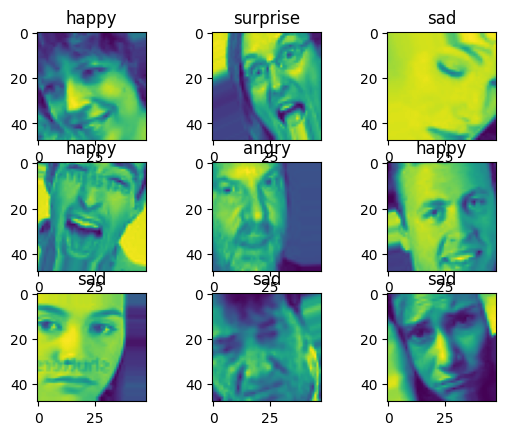

In [206]:
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_datagen.fit(np.array(list(train_data['images'])))

for X_batch, y_batch in train_datagen.flow(np.array(list(train_data['images'])), np.array(list(train_data['labels'])), batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.title(y_batch[i])
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break